# Liesel-GAM Demo Notebook

## Setup and Imports

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [62]:
def gen_tp_data(n=400, noise_sd=0.3, grid=False, seed=1):
    """
    Generate test data for tensor-product smooths with clear anisotropy.

    Parameters
    ----------
    n : int
        Number of samples (if grid=False).
    noise_sd : float
        Standard deviation of Gaussian noise.
    grid : bool
        If True, generate approximately n points on a regular grid.
        If False, generate random design points.
    seed : int
        Random seed.

    Returns
    -------
    pandas.DataFrame with columns: x, y, eta (signal), z (noisy response)
    """
    rng = np.random.default_rng(seed)

    # --- Design ----
    if grid:
        m = int(np.ceil(np.sqrt(n)))
        xs = np.linspace(0, 1, m)
        ys = np.linspace(0, 1, m)
        x, y = np.meshgrid(xs, ys, indexing="xy")
        x = x.ravel()
        y = y.ravel()
    else:
        x = rng.uniform(0, 1, n)
        y = rng.uniform(0, 1, n)

    # --- True anisotropic smooth ----
    def f_true(x, y):
        # 1) Fast variation in x, slow in y
        term1 = 1.5 * np.sin(6 * np.pi * x) * np.cos(1 * np.pi * y)

        # 2) Anisotropic Gaussian bump: elongated + rotated
        x0, y0 = 0.65, 0.35
        a_x, a_y = 0.10, 0.35  # different length scales: much tighter in x
        rho = 0.7  # correlation -> rotated ellipse

        X = x - x0
        Y = y - y0
        quad = (X**2) / (a_x**2) + (Y**2) / (a_y**2) + 2 * rho * X * Y / (a_x * a_y)
        term2 = 2.0 * np.exp(-quad)

        # 3) Mild linear trend (mainly in y for additional anisotropy)
        term3 = 0.5 * y

        return term1 + term2 + term3

    eta = f_true(x, y)
    z = eta + rng.normal(scale=noise_sd, size=len(eta))

    return pd.DataFrame({"x": x, "y": y, "eta": eta, "z": z})

In [63]:
df = gen_tp_data(n=600, noise_sd=0.25, grid=False, seed=42)
print(df.head())

          x         y       eta         z
0  0.773956  0.477506  0.534281  0.287991
1  0.438878  0.761433 -0.434527 -0.649737
2  0.858598  0.903328  1.107858  1.722214
3  0.697368  0.720696  0.093873  0.544309
4  0.094177  0.963211 -0.977369 -1.080306


In [64]:
df_grid = gen_tp_data(n=5000, grid=True)

In [65]:
df_grid

,x,y,eta,z
0,0.000000,0.0,3.678865e-23,0.103675
1,0.014286,0.0,3.990553e-01,0.645541
2,0.028571,0.0,7.693489e-01,0.868480
3,0.042857,0.0,1.084192e+00,0.693245
4,0.057143,0.0,1.320893e+00,1.592500
...,...,...,...,...
5036,0.942857,1.0,1.820893e+00,1.616454
5037,0.957143,1.0,1.584192e+00,1.591152
5038,0.971429,1.0,1.269349e+00,1.251839
5039,0.985714,1.0,8.990553e-01,0.794860


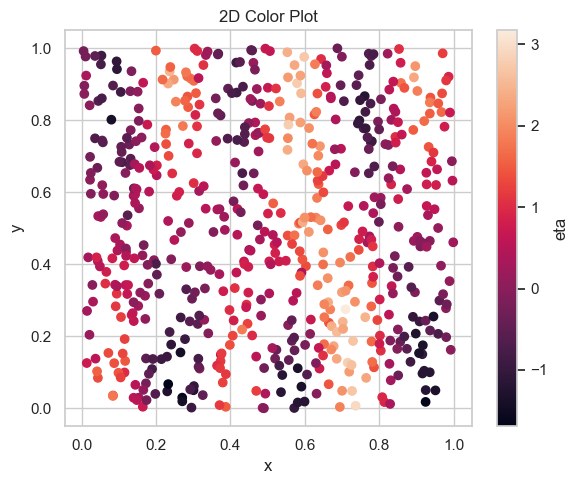

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df["x"], df["y"], c=df["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

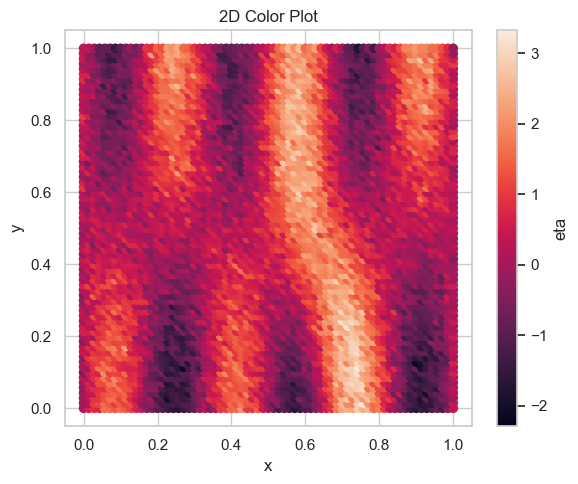

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

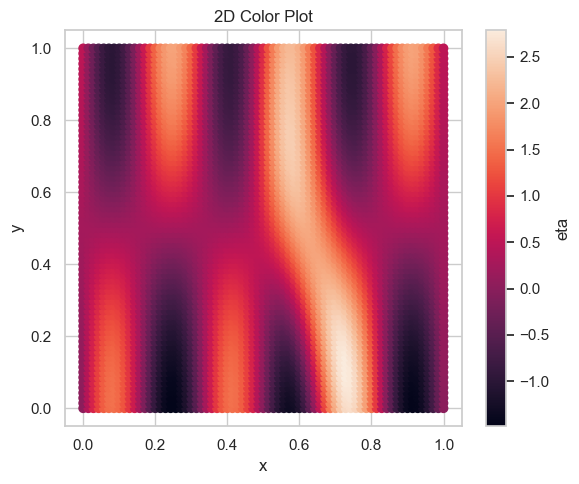

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["eta"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [69]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [ ]:
import tensorflow_probability.substrates.jax.bijectors as tfb


def scale_fn():
    prior = lsl.Dist(
        tfd.HalfNormal,
        scale=jnp.array(20.0),
    )

    scale = lsl.Var.new_param(
        jnp.array(0.1),
        distribution=prior,
        name="{x}",  # {x} is a placeholder for the automatically generated name
    )

    scale.transform(
        tfb.Softplus(),
        inference=gs.MCMCSpec(gs.IWLSKernel.untuned),
        name="h({x})",  # {x} is a placeholder for the automatically generated name
    )
    return scale


tb = gam.TermBuilder.from_df(df, default_scale_fn=scale_fn)

In [ ]:
loc += tb.ps("x", k=15)
loc += tb.ps("y", k=15)

psx = tb.ps("x", k=12)
psy = tb.ps("y", k=12)
loc += tb.tx(psx, psy)

liesel.model.model - INFO - Unnamed variables and/or nodes were temporarily named.
liesel.model.model - INFO - Unnamed variables and/or nodes were temporarily named.
liesel.model.model - INFO - Unnamed variables and/or nodes were temporarily named.
liesel.model.model - INFO - Unnamed variables and/or nodes were temporarily named.
liesel.model.model - INFO - Unnamed variables and/or nodes were temporarily named.
liesel.model.model - INFO - Unnamed variables and/or nodes were temporarily named.


### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="z_value").value


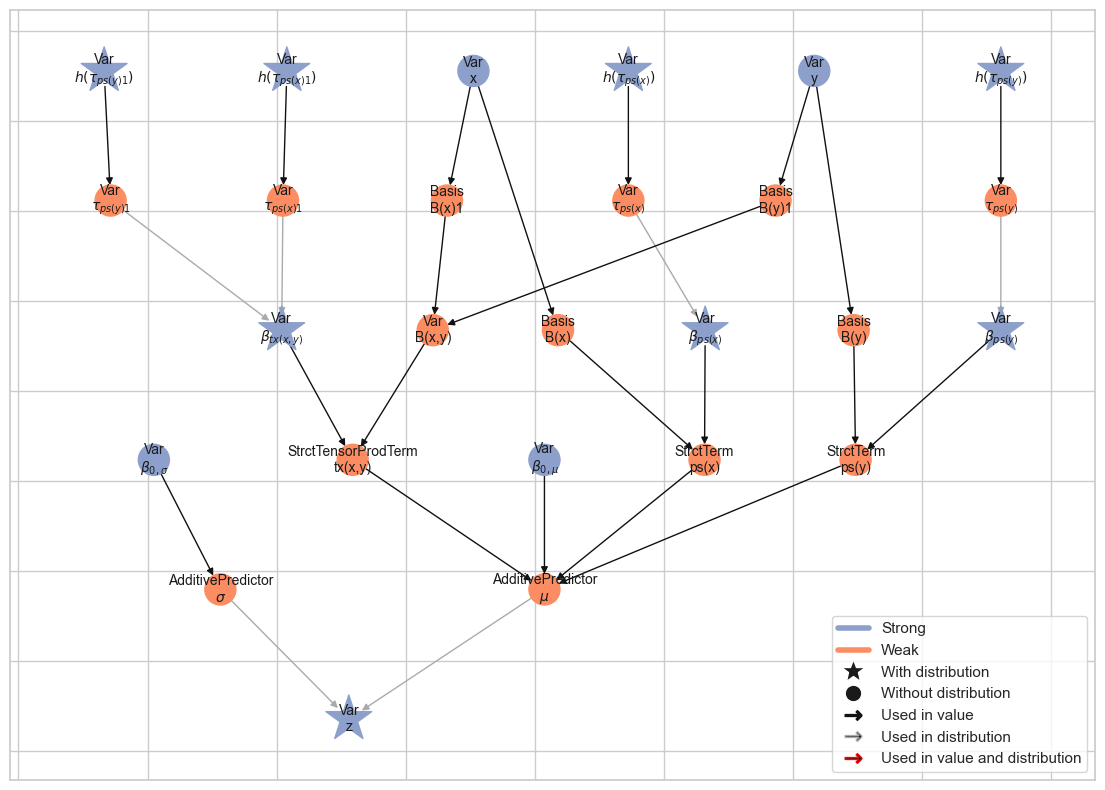

In [72]:
model = lsl.Model([z])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [73]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_burnin(9000)
eb.add_posterior(10_000, thinning=10)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{tx(x,y)}$', '$h(\\tau_{ps(y)1})$', '$h(\\tau_{ps(x)1})$', '$\\beta_{ps(y)}$', '$h(\\tau_{ps(y)})$', '$\\beta_{ps(x)}$', '$h(\\tau_{ps(x)})$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...


liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: BURNIN, 9000 transitions, 1000 jitted together
100%|██████████████████████████████████████████| 9/9 [00:16<00:00,  1.80s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 98, 131, 86, 187 / 9000 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_06: 1, 2, 0, 0 / 9000 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_08: 0, 0, 0, 1 / 9000 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Finished warmup
liesel.goose.engine - INFO - Starting epoch: POSTERIOR, 10000 transitions, 1000 jitted together
100%|████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 102, 134, 125, 86 / 10000 transitions
liesel.goose.engine - INFO - Finished epoch


### MCMC summary

In [74]:
summary = gs.Summary(results)

diagnostics = (
    summary.to_dataframe()
    .reset_index()
    .loc[:, ["variable", "rhat", "ess_bulk", "ess_tail"]]
    .groupby("variable", as_index=False)
    .agg(
        ess_bulk_min=("ess_bulk", "min"),
        ess_bulk_median=("ess_bulk", "median"),
        ess_tail_min=("ess_tail", "min"),
        ess_tail_median=("ess_tail", "median"),
        rhat_max=("rhat", "max"),
        rhat_median=("rhat", "median"),
    )
)
diagnostics

,variable,ess_bulk_min,ess_bulk_median,ess_tail_min,ess_tail_median,rhat_max,rhat_median
0,"$\beta_{0,\mu}$",3462.896552,3462.896552,3971.821514,3971.821514,0.999980,0.999980
1,"$\beta_{0,\sigma}$",1714.968302,1714.968302,3156.451084,3156.451084,1.001771,1.001771
2,$\beta_{ps(x)}$,2959.340401,3356.949143,3159.991131,3564.955643,1.000882,1.000310
3,$\beta_{ps(y)}$,972.692095,2570.674621,1053.449790,1811.904879,1.009289,1.005640
4,"$\beta_{tx(x,y)}$",296.036192,1470.770746,762.940032,1676.058803,1.027204,1.003761
5,$h(\tau_{ps(x)1})$,2984.802337,2984.802337,2400.330161,2400.330161,1.000311,1.000311
6,$h(\tau_{ps(x)})$,2884.180663,2884.180663,3245.705437,3245.705437,0.999375,0.999375
7,$h(\tau_{ps(y)1})$,146.451802,146.451802,273.063630,273.063630,1.046364,1.046364
8,$h(\tau_{ps(y)})$,400.777781,400.777781,741.368895,741.368895,1.021970,1.021970


In [75]:
summary.error_df()

count  \
kernel    error_code error_msg                                          phase             
kernel_04 2          indefinite information matrix (fallback to iden... warmup      358   
                                                                        posterior   416   
          90         nan acceptance prob                                warmup      144   
                                                                        posterior    31   
kernel_06 2          indefinite information matrix (fallback to iden... warmup        3   
                                                                        posterior     0   
kernel_08 90         nan acceptance prob                                warmup        1   
                                                                        posterior     0   

                                                                                  sample_size  \
kernel    error_code error_msg                                          phase                   
kernel_04 2          indefinite information matrix (fallback to iden... warmup          36000   
                                                                        posterior        4000   
          90         nan acceptance prob                                warmup          36000   
                                                                        posterior        4000   
kernel_06 2          indefinite information matrix (fallback to iden... warmup          36000   
                                                                        posterior        4000   
kernel_08 90         nan acceptance prob                                warmup          36000   
                                                                        posterior        4000   

                                                                                  sample_size_total  \
kernel    error_code error_msg                                          phase                         
kernel_04 2          indefinite information matrix (fallback to iden... warmup                36000   
                                                                        posterior             40000   
          90         nan acceptance prob                                warmup                36000   
                                                                        posterior             40000   
kernel_06 2          indefinite information matrix (fallback to iden... warmup                36000   
                                                                        posterior             40000   
kernel_08 90         nan acceptance prob                                warmup                36000   
                                                                        posterior             40000   

                                                                                   relative  
kernel    error_code error_msg                                          phase                
kernel_04 2          indefinite information matrix (fallback to iden... warmup     0.009944  
                                                                        posterior    0.0104  
          90         nan acceptance prob                                warmup        0.004  
                                                                        posterior  0.000775  
kernel_06 2          indefinite information matrix (fallback to iden... warmup     0.000083  
                                                                        posterior       0.0  
kernel_08 90         nan acceptance prob                                warmup     0.000028  
                                                                        posterior       0.0

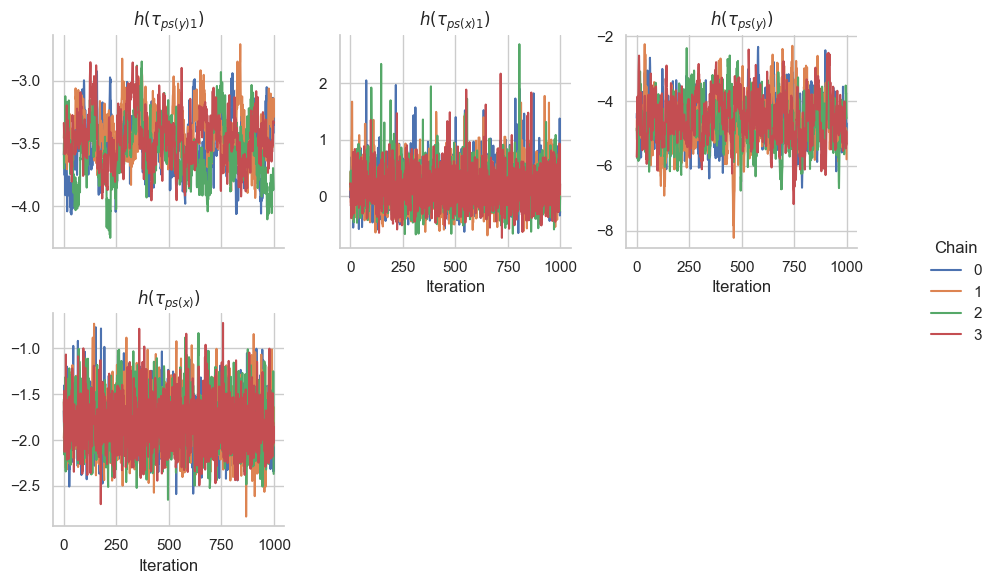

In [76]:
gs.plot_trace(results, [n for n in model.parameters if "tau" in n])

In [77]:
samples = results.get_posterior_samples()

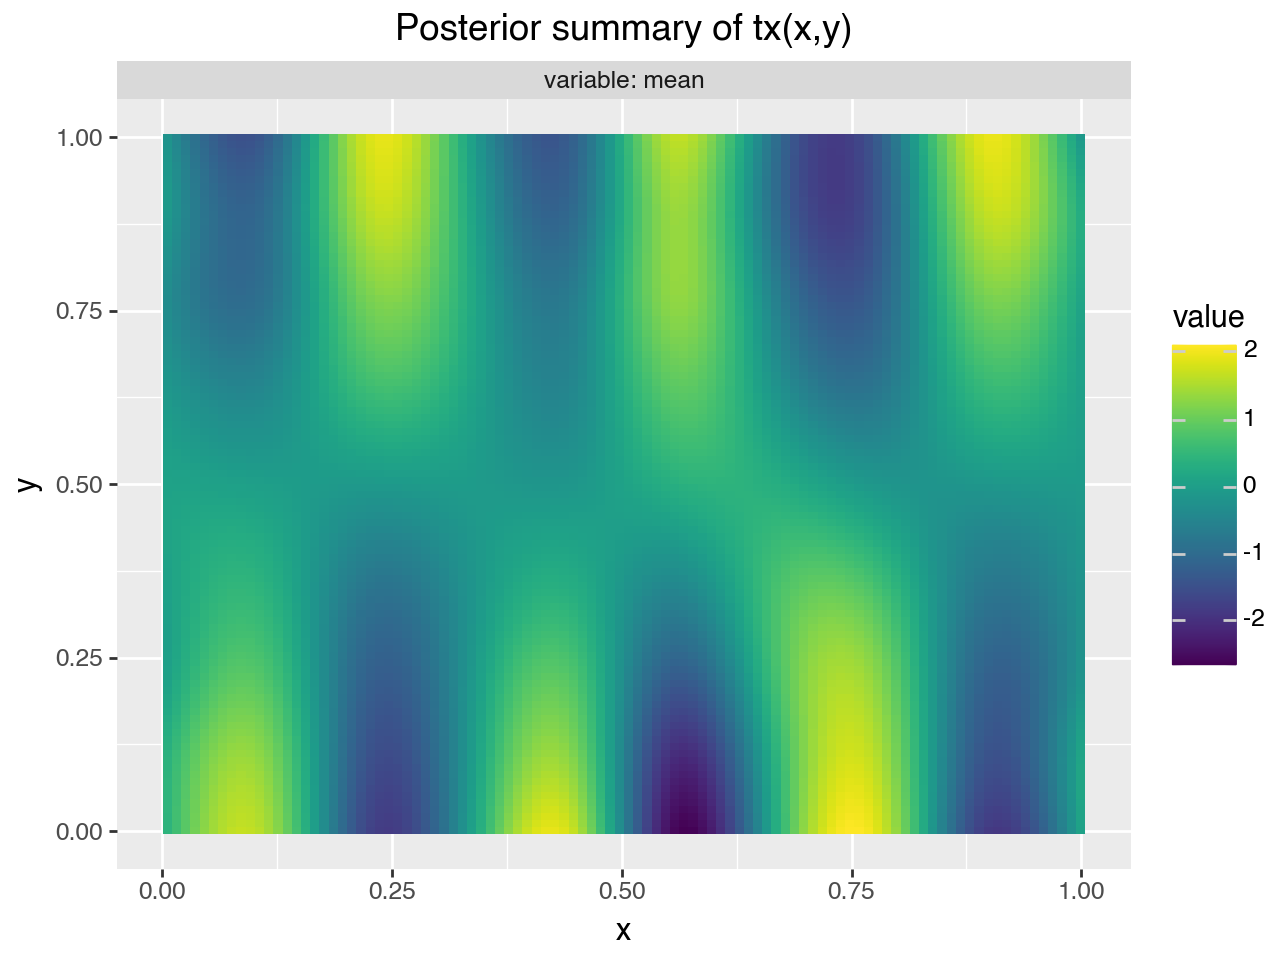

In [78]:
gam.plot_2d_smooth(model.vars["tx(x,y)"], samples, ngrid=100)

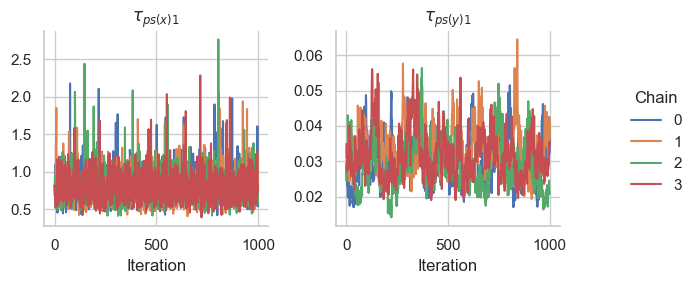

In [79]:
gs.plot_trace(
    model.predict(samples, predict=[s.name for s in model.vars["tx(x,y)"].scales])
)

### MCMC trace plots

## Predictions

In [80]:
samples = results.get_posterior_samples()

### Predict variables at new x values

In [81]:
predictions = model.predict(
    samples=samples,
    predict=["tx(x,y)", "$\\mu$", "ps(x)", "ps(y)"],
    newdata={"x": df_grid.x.to_numpy(), "y": df_grid.y.to_numpy()},
)

predictions_summary = (
    gs.SamplesSummary(predictions, which=["mean", "quantiles"])
    .to_dataframe()
    .reset_index()
)

In [82]:
predictions_summary["x"] = np.tile(df_grid.x.to_numpy(), len(predictions))
predictions_summary["y"] = np.tile(df_grid.y.to_numpy(), len(predictions))

In [83]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,q_0.05,q_0.5,q_0.95,x,y
0,$\mu$,$\mu$[0],"(0,)",4000,0.218656,-0.795756,0.211472,1.222986,0.000000,0.0
1,$\mu$,$\mu$[1],"(1,)",4000,0.585327,-0.199742,0.580160,1.359468,0.014286,0.0
2,$\mu$,$\mu$[2],"(2,)",4000,0.927770,0.295860,0.928637,1.546425,0.028571,0.0
3,$\mu$,$\mu$[3],"(3,)",4000,1.228256,0.698391,1.232928,1.741451,0.042857,0.0
4,$\mu$,$\mu$[4],"(4,)",4000,1.469599,1.020538,1.480580,1.904699,0.057143,0.0


### Plot fitted functions

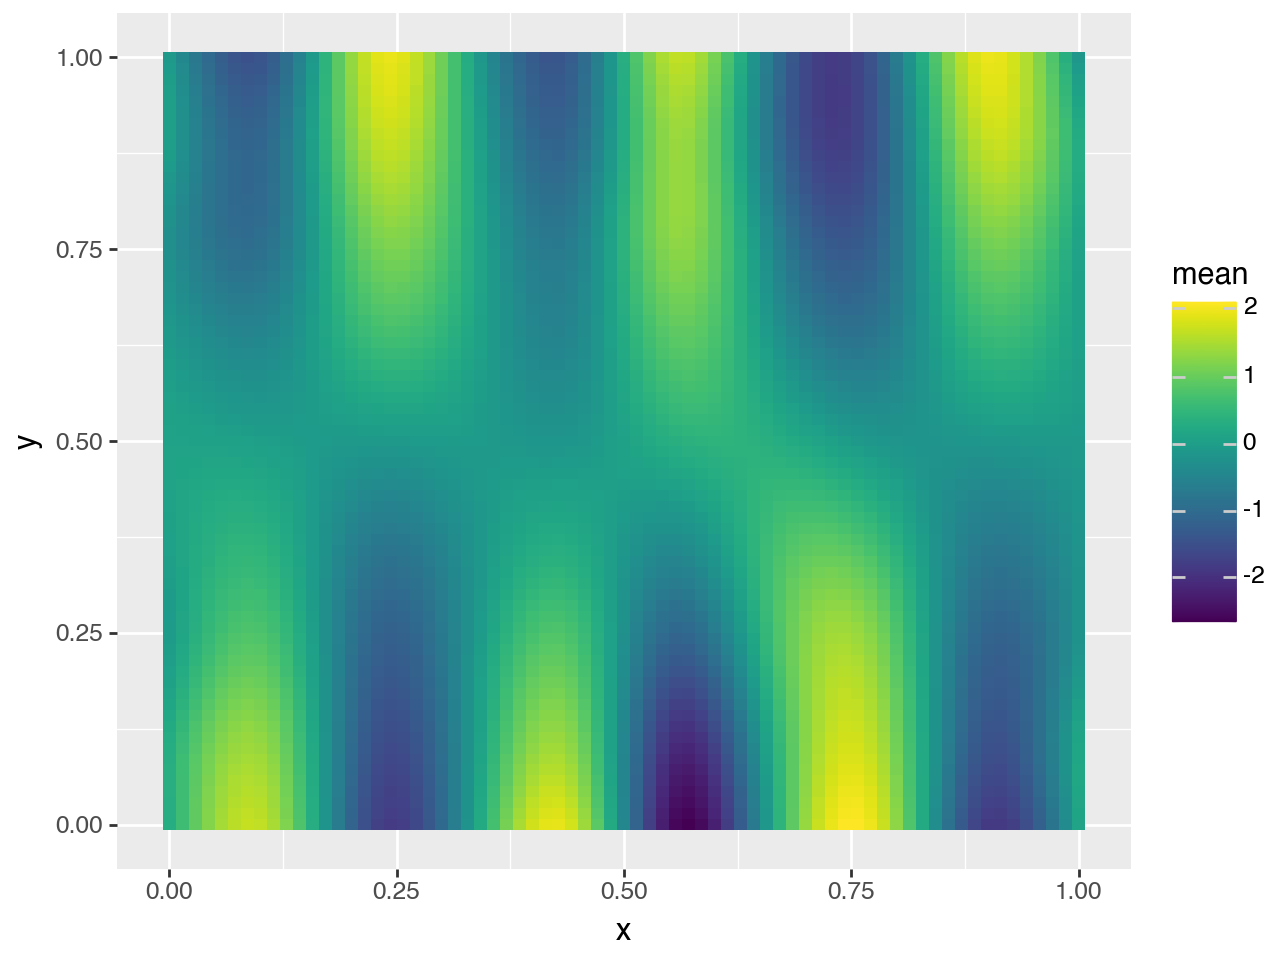

In [84]:
select = predictions_summary["variable"].isin(["tx(x,y)"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

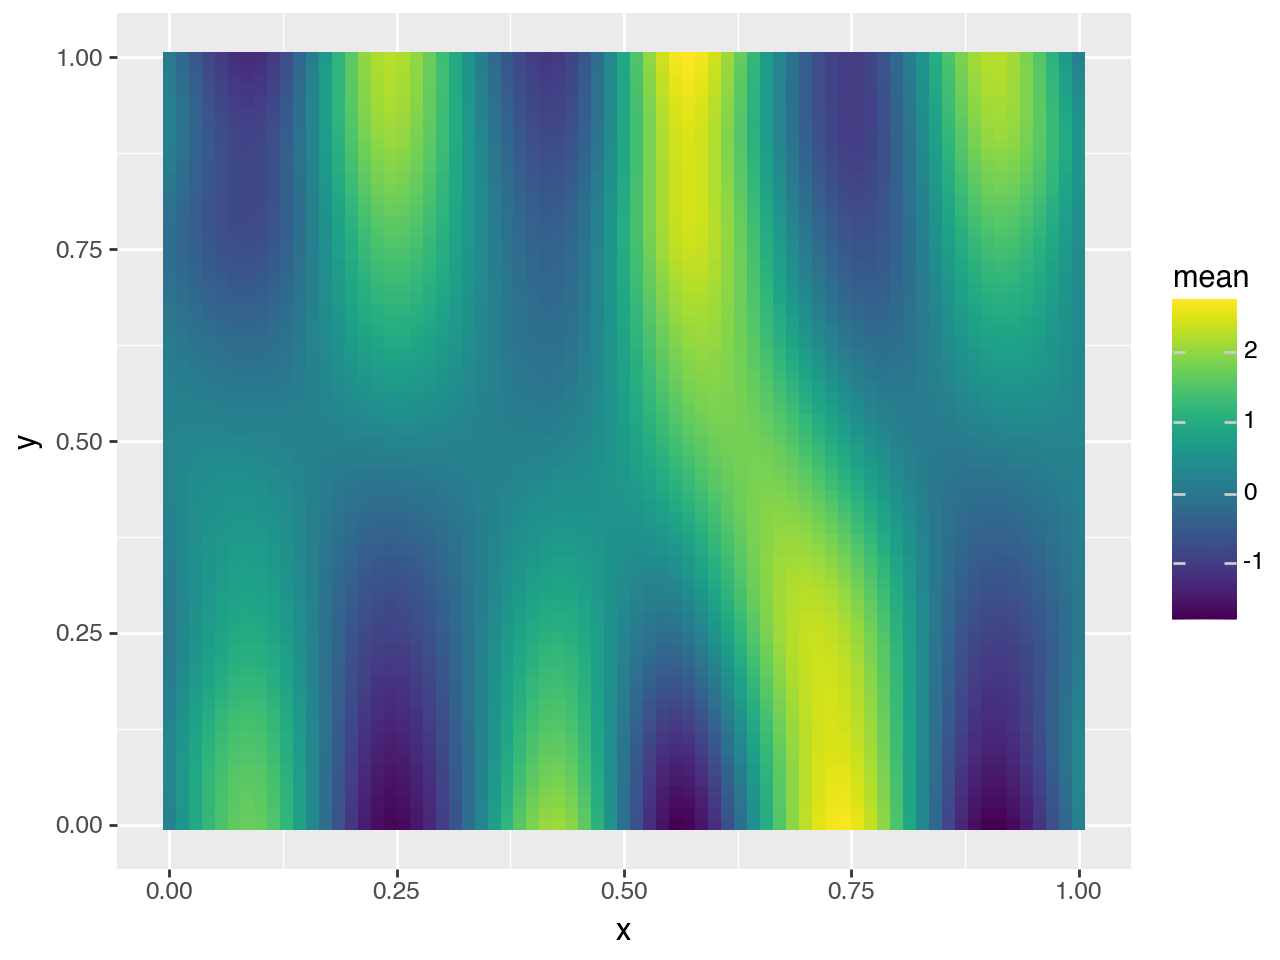

In [85]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

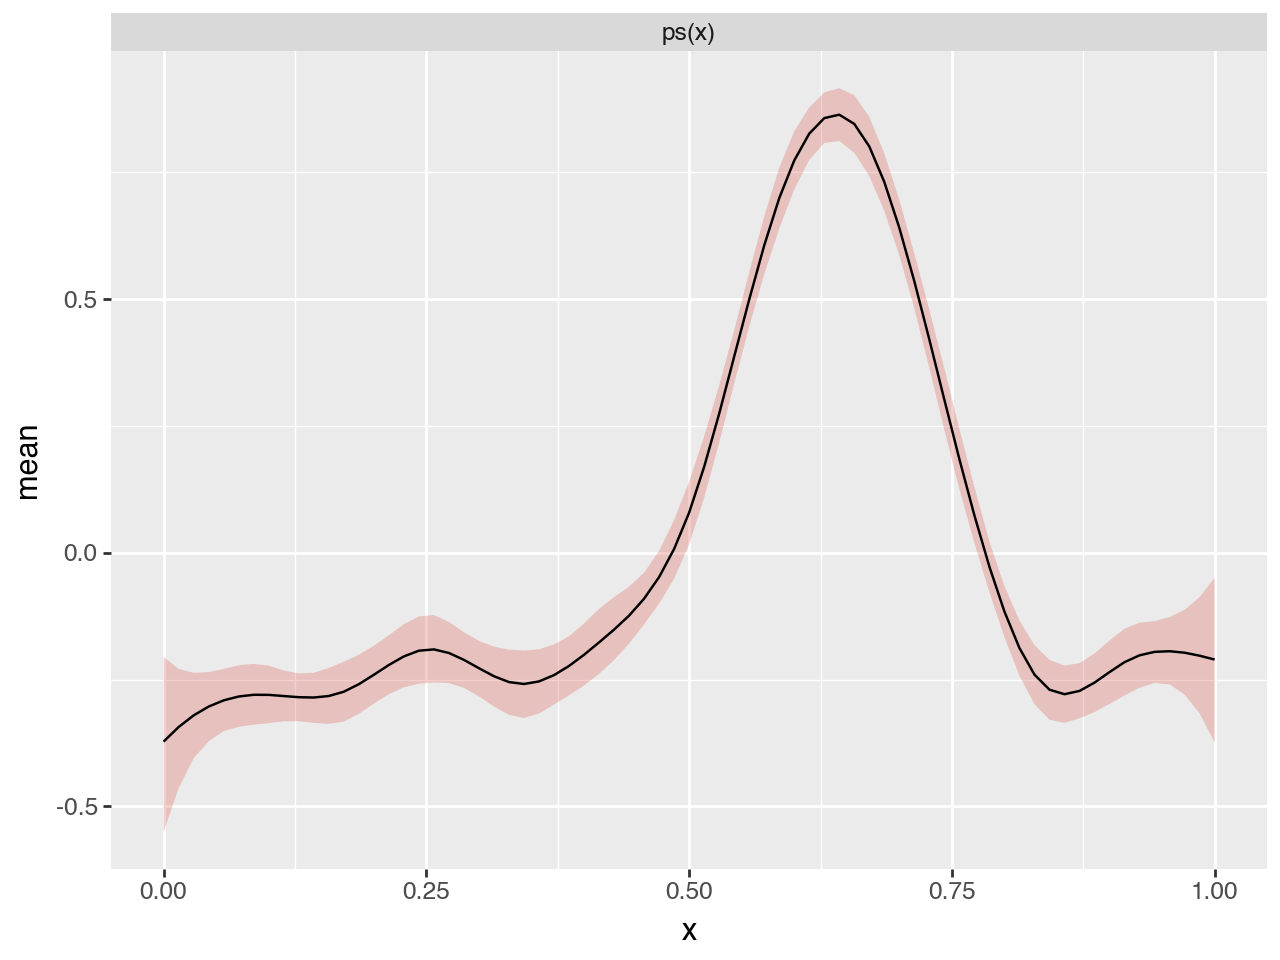

In [86]:
select = predictions_summary["variable"].isin(["ps(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

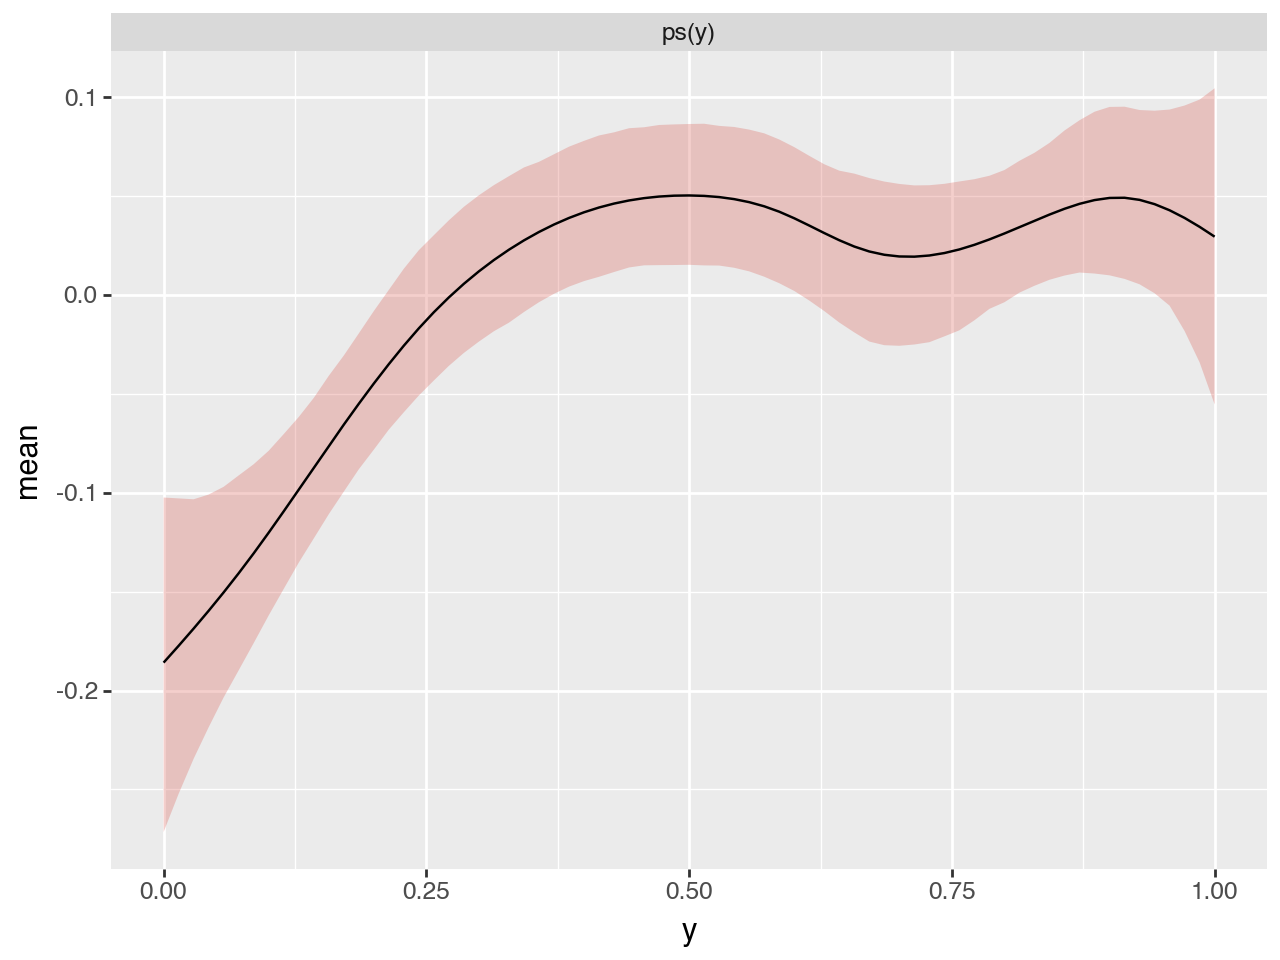

In [87]:
select = predictions_summary["variable"].isin(["ps(y)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("y", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("y", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)